In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
W = 32 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 32 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [4]:
## get images / labels

Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 32, 32, 3), (6400,))

In [5]:
Classes

array([0., 3., 2., ..., 2., 2., 3.], dtype=float32)

In [6]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 32, 32, 3), (5120,), (1280, 32, 32, 3), (1280,))

In [8]:
y_test

array([2., 0., 3., ..., 3., 2., 3.], dtype=float32)

In [9]:
from keras.utils import np_utils

In [10]:
y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [15]:

y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [20]:
y_test

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 32, 32, 3), (5120, 4), (1280, 32, 32, 3), (1280, 4))

In [17]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [19]:
num_classes = 4
input_shape = (32, 32, 3)

In [21]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 32, 32, 3), (5120, 4), (1280, 32, 32, 3), (1280, 4))

In [22]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-10-06 00:59:26.996825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 00:59:26.997949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 00:59:26.998704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 00:59:26.999696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [25]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


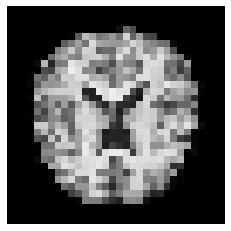

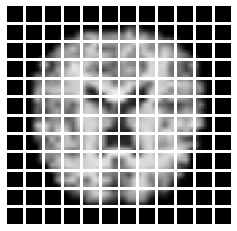

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [27]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [28]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [67]:
from matplotlib import pyplot
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,cohen_kappa_score,roc_auc_score,plot_confusion_matrix,classification_report

In [55]:
    model = create_vit_classifier()
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    

Epoch 1/100
18/18 [==============================] - 12s 296ms/step - loss: 4.8726 - accuracy: 0.3993 - top-5-accuracy: 1.0000 - val_loss: 1.0417 - val_accuracy: 0.5059 - val_top-5-accuracy: 1.0000
Epoch 2/100
18/18 [==============================] - 4s 249ms/step - loss: 1.1088 - accuracy: 0.4737 - top-5-accuracy: 1.0000 - val_loss: 0.9848 - val_accuracy: 0.5195 - val_top-5-accuracy: 1.0000
Epoch 3/100
18/18 [==============================] - 4s 239ms/step - loss: 1.0246 - accuracy: 0.4993 - top-5-accuracy: 1.0000 - val_loss: 0.9742 - val_accuracy: 0.5176 - val_top-5-accuracy: 1.0000
Epoch 4/100
18/18 [==============================] - 4s 240ms/step - loss: 1.0043 - accuracy: 0.5013 - top-5-accuracy: 1.0000 - val_loss: 0.9503 - val_accuracy: 0.5254 - val_top-5-accuracy: 1.0000
Epoch 5/100
18/18 [==============================] - 4s 241ms/step - loss: 0.9901 - accuracy: 0.5098 - top-5-accuracy: 1.0000 - val_loss: 0.9641 - val_accuracy: 0.5137 - val_top-5-accuracy: 1.0000
Epoch 6/100
18

In [56]:
y_pred = np.argmax(model.predict(x_test), axis=1)

In [57]:

y_true = np.argmax(y_test, axis=1)
print(y_pred)
print(y_pred.shape)

[3 3 2 ... 3 3 3]
(1280,)


In [58]:
print(y_true)
print(y_true.shape)

[2 0 3 ... 3 2 3]
(1280,)


In [68]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.19      0.30       156
           1       0.00      0.00      0.00         9
           2       0.82      0.59      0.68       664
           3       0.47      0.79      0.59       451

    accuracy                           0.61      1280
   macro avg       0.50      0.39      0.39      1280
weighted avg       0.68      0.61      0.60      1280



In [59]:
accuracy = accuracy_score(y_true,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred , average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true,y_pred,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.607031
Precision: 0.677154
Recall: 0.607031
F1 score: 0.599264


In [60]:
    # kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, model.predict(x_test))
    print('ROC AUC: %f' % auc)
   

Cohens kappa: 0.337696
ROC AUC: 0.717439


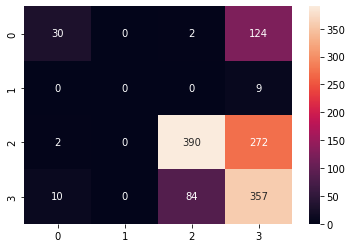

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true, y_pred)
f = sns.heatmap(cnf_matrix, annot=True, fmt='d')

In [77]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [80]:
print(FP)

[ 12.   0.  86. 405.]


In [81]:
TPR = TP/(TP+FN)

In [82]:
print(TPR)

[0.19230769 0.         0.5873494  0.79157428]


In [87]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity: %f' % TPR.sum())
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity: %f' % TNR.sum())
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

Sensitivity: 1.571231
Specificity: 3.361173


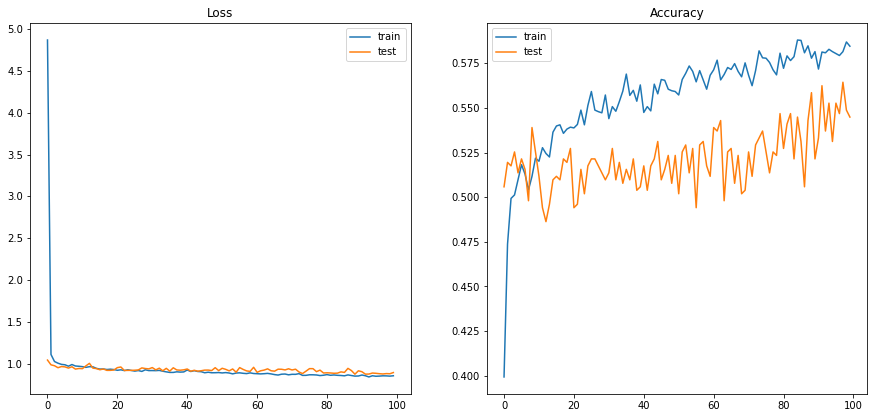

In [65]:
plt.figure(figsize=(15, 15))
# plot loss during training
pyplot.subplot(221)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(222)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()